In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.preprocessing import LabelBinarizer
import torch
# from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration, WhisperTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
from mne_bids import BIDSPath
import mne
from scipy.stats import pearsonr, zscore
from functools import partial

/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
base_path = "/srv/nfs-data/sisko"
bids_root = base_path + "/storage/ECoG_podcast/ds005574-1.0.2" 
context_len = 32
subject = '03' # --> 08 con cura 
ecog_sr = 512
ecog_sr_down = 32
whisper_sr = 16000
tmax = 2.0
pre_stimulus = 2.0
pre_audio = 0.2
func = partial(zscore) 


In [3]:
# model_w = WhisperModel.from_pretrained("openai/whisper-base")
# feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
# tokenizer_w = WhisperTokenizer.from_pretrained("openai/whisper-base")
# processor_w = AutoProcessor.from_pretrained("openai/whisper-base")
# model_w.eval()

from transformers import GPT2TokenizerFast, GPT2Model, AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer_gpt = AutoTokenizer.from_pretrained(model_name)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = AutoModelForCausalLM.from_pretrained(model_name)
model_gpt.eval()
model_gpt.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## From Paper

In [4]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.head(10)

,word,start,end
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111
5,middle.,5.151,5.391
6,So,6.592,6.732
7,there's,6.752,6.912
8,some,6.892,7.052
9,places,7.072,7.342


In [4]:
modelname = "en_core_web_sm"
nlp = spacy.load(modelname)

In [5]:
df.insert(0, "word_idx", df.index.values)
df["word_with_ws"] = df.word.astype(str) + " "
df["hftoken"] = df.word_with_ws.apply(nlp.tokenizer)
df = df.explode("hftoken", ignore_index=True)
df.head(10)

,word_idx,word,start,end,word_with_ws,hftoken
0,0,Act,3.710,3.790,Act,Act
1,1,"one,",3.990,4.190,"one,",one
2,1,"one,",3.990,4.190,"one,",","
3,2,monkey,4.651,4.931,monkey,monkey
4,3,in,4.951,5.011,in,in
5,4,the,5.051,5.111,the,the
6,5,middle.,5.151,5.391,middle.,middle
7,5,middle.,5.151,5.391,middle.,.
8,6,So,6.592,6.732,So,So
9,7,there's,6.752,6.912,there's,there


In [6]:
words = [token.text for token in df.hftoken.tolist()]
spaces = [token.whitespace_ == " " for token in df.hftoken.tolist()]
doc = spacy.tokens.Doc(nlp.vocab, words=words, spaces=spaces)
doc = nlp(doc)

In [7]:
features = []
for token in doc:
    features.append([token.text, token.tag_, token.dep_, token.is_stop])

df2 = pd.DataFrame(
        features, columns=["token", "pos", "dep", "stop"], index=df.index
    )
df = pd.concat([df, df2], axis=1)
df.drop(["hftoken", "word_with_ws"], axis=1, inplace=True)
df.head(10)

,word_idx,word,start,end,token,pos,dep,stop
0,0,Act,3.710,3.790,Act,NNP,ROOT,False
1,1,"one,",3.990,4.190,one,CD,nummod,True
2,1,"one,",3.990,4.190,",",",",punct,False
3,2,monkey,4.651,4.931,monkey,NN,appos,False
4,3,in,4.951,5.011,in,IN,prep,True
5,4,the,5.051,5.111,the,DT,det,True
6,5,middle.,5.151,5.391,middle,NN,pobj,False
7,5,middle.,5.151,5.391,.,.,punct,False
8,6,So,6.592,6.732,So,RB,advmod,True
9,7,there's,6.752,6.912,there,EX,expl,True


In [8]:
taggerEncoder = LabelBinarizer().fit(nlp.get_pipe("tagger").labels)
dependencyEncoder = LabelBinarizer().fit(nlp.get_pipe("parser").labels)

a = taggerEncoder.transform(df.pos.tolist())
b = dependencyEncoder.transform(df.dep.tolist())
c = LabelBinarizer().fit_transform(df.stop.tolist())
embeddings = np.hstack((a, b, c))
print(f"Embeddings have a shape of: {embeddings.shape}")

Embeddings have a shape of: (5305, 96)


### From GPT2

In [9]:
import torch
from accelerate import Accelerator, find_executable_batch_size
from transformers import AutoModelForCausalLM, AutoTokenizer

In [10]:
df = pd.read_csv(transcript_path)

modelname = "gpt2"
context_len = 32
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda", 0)
    print("Using cuda!")

# Load model
tokenizer = AutoTokenizer.from_pretrained(modelname)

df.insert(0, "word_idx", df.index.values)
df["hftoken"] = df.word.apply(lambda x: tokenizer.tokenize(" " + x))

df = df.explode("hftoken", ignore_index=True)
df["token_id"] = df.hftoken.apply(tokenizer.convert_tokens_to_ids)

df.head(10)



Using cuda!


,word_idx,word,start,end,hftoken,token_id
0,0,Act,3.710,3.790,ĠAct,2191
1,1,"one,",3.990,4.190,Ġone,530
2,1,"one,",3.990,4.190,",",11
3,2,monkey,4.651,4.931,Ġmonkey,21657
4,3,in,4.951,5.011,Ġin,287
5,4,the,5.051,5.111,Ġthe,262
6,5,middle.,5.151,5.391,Ġmiddle,3504
7,5,middle.,5.151,5.391,.,13
8,6,So,6.592,6.732,ĠSo,1406
9,7,there's,6.752,6.912,Ġthere,612


In [11]:
model = AutoModelForCausalLM.from_pretrained(modelname)
model = model.eval()
model = model.to(device)

In [12]:
token_ids = df.token_id.tolist()
fill_value = 0
if tokenizer.pad_token_id is not None:
    fill_value = tokenizer.pad_token_id

data = torch.full((len(token_ids), context_len + 1), fill_value, dtype=torch.long)
for i in range(len(token_ids)):
    example_tokens = token_ids[max(0, i - context_len) : i + 1]
    data[i, -len(example_tokens) :] = torch.tensor(example_tokens)

print(f"Data has a shape of: {data.shape}")

Data has a shape of: torch.Size([5491, 33])


In [13]:
import tqdm

accelerator = Accelerator()

@find_executable_batch_size(starting_batch_size=32)
def inference_loop(batch_size=32):
    # nonlocal accelerator  # Ensure they can be used in our context
    accelerator.free_memory()  # Free all lingering references

    data_dl = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=False
        )

    top_guesses = []
    ranks = []
    true_probs = []
    entropies = []
    embeddings = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_dl):
            # Get output from model
            output = model(batch.to(device), output_hidden_states=True)
            logits = output.logits
            states = output.hidden_states

            true_ids = batch[:, -1]
            brange = list(range(len(true_ids)))
            logits_order = logits[:, -2, :].argsort(descending=True)
            batch_top_guesses = logits_order[:, 0]
            batch_ranks = torch.eq(logits_order, true_ids.reshape(-1, 1).to(device)).nonzero()[:, 1]
            batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
            batch_true_probs = batch_probs[brange, true_ids]
            batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
            batch_embeddings = [state[:,-1,:].numpy(force=True) for state in states ]

            top_guesses.append(batch_top_guesses.numpy(force=True))
            ranks.append(batch_ranks.numpy(force=True))
            true_probs.append(batch_true_probs.numpy(force=True))
            entropies.append(batch_entropy.numpy(force=True))
            embeddings.append(batch_embeddings)

        return top_guesses, ranks, true_probs, entropies, embeddings

top_guesses, ranks, true_probs, entropies, embeddings = inference_loop()

100%|██████████| 172/172 [00:02<00:00, 76.22it/s]


In [14]:
df["rank"] = np.concatenate(ranks)
df["true_prob"] = np.concatenate(true_probs)
df["top_pred"] = np.concatenate(top_guesses)
df["entropy"] = np.concatenate(entropies)

df.head(10)

,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,3185,1.000214e-08,0,0.092733
1,1,"one,",3.990,4.190,Ġone,530,46,2.847536e-03,352,5.294111
2,1,"one,",3.990,4.190,",",11,2,8.006244e-02,0,4.976886
3,2,monkey,4.651,4.931,Ġmonkey,21657,6978,6.075798e-06,734,5.869668
4,3,in,4.951,5.011,Ġin,287,24,1.004819e-03,0,2.478674
5,4,the,5.051,5.111,Ġthe,262,0,3.898531e-01,262,4.340648
6,5,middle.,5.151,5.391,Ġmiddle,3504,2,4.331167e-02,5228,5.842119
7,5,middle.,5.151,5.391,.,13,3,4.237045e-02,286,2.115348
8,6,So,6.592,6.732,ĠSo,1406,116,1.016019e-03,2191,5.861632
9,7,there's,6.752,6.912,Ġthere,612,16,8.699343e-03,11,5.248995


In [15]:
print(f"There are {len(embeddings[0])} layers of embeddings")
print(f"Each word embedding is {embeddings[0][0].shape} dimensions long")

There are 13 layers of embeddings
Each word embedding is (32, 768) dimensions long


In [16]:
layer_index = -1

all_embeddings = np.concatenate(
    [batch[layer_index] for batch in embeddings],  # ogni elemento ha shape (batch_size, 33, 768)
    axis=0  
)

print(all_embeddings.shape)

(5491, 768)


In [17]:
# transcript_path = f"{bids_root}/stimuli/gpt2-xl/transcript.tsv"
df_contextual = df
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

Model accuracy: 26.935%


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,3185,1.000214e-08,0,0.092733
1,1,"one,",3.990,4.190,Ġone,530,46,2.847536e-03,352,5.294111
2,1,"one,",3.990,4.190,",",11,2,8.006244e-02,0,4.976886
3,2,monkey,4.651,4.931,Ġmonkey,21657,6978,6.075798e-06,734,5.869668
4,3,in,4.951,5.011,Ġin,287,24,1.004819e-03,0,2.478674


In [18]:
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = all_embeddings[indices].mean(0) # average features
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 768)


In [19]:
df_word = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


In [20]:
df_word.to_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv", index=False)
torch.save(torch.tensor(aligned_embeddings), "/srv/nfs-data/sisko/matteoc/podcast/text_embeds_gpt.pt")

## Start from Here

In [76]:
# from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoFeatureExtractor, AutoProcessor, WhisperTokenizer
# import torchaudio

# model_name = "openai/whisper-base"

# model_w = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# tokenizer_w = WhisperTokenizer.from_pretrained(model_name)
# processor_w = AutoProcessor.from_pretrained(model_name)
# model_w.eval()
# model_w.to(device)

In [4]:
from utils import preprocess_raw_audio
from scipy.io import wavfile

file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     suffix="ieeg",
                     extension="fif")


transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
events = np.zeros((len(df), 3))
events[:, 0] = df.start

audio_path = f"{bids_root}/stimuli/podcast.wav"
audio_sf, audio_wave = wavfile.read(audio_path)
audio_wave_clean = preprocess_raw_audio(audio_wave, audio_sf)

/tmp/ipykernel_2011135/1920131353.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [198]:
from torch.nn.utils.rnn import pad_sequence
import tqdm

download_text = True

def get_text_and_brain(file_path, df, tmax=2.0, pre_audio=2.0, pre_stimulus=2.0,
                          model=None, tokenizer=None,
                          device=device, context_len=32):
    
    model = model.to(device)

    raw = mne.io.read_raw_fif(file_path, verbose=False)
    raw.load_data()
    raw = raw.apply_function(func, channel_wise=True, verbose=False)

    # events = np.zeros((len(df), 3), dtype=int)
    # events[:, 0] = (df.start * raw.info['sfreq']).astype(int)
    df.dropna(subset=['start'], inplace=True)
    df.sort_values("start", inplace=True)
    events = np.zeros((len(df), 3))
    events[:, 0] = df.start

    epochs = mne.Epochs(
        raw,
        (events * raw.info['sfreq']).astype(int),
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

    if download_text:
        text_decoder_embd = []
        attention_mask_list = []

        for row_idx in tqdm.tqdm(good_idx):
            
            row = df.iloc[row_idx]
            word_list = df[
                (df["start"] >= row["start"] - pre_audio) & 
                (df["start"] <= row["start"])
            ]
            words_in_segment = word_list["word"].tolist()
            transcription = " ".join(words_in_segment)

            # row = df.iloc[row_idx]
            # current_idx = row.name  
            # start_idx = max(0, current_idx - context_len)
            # end_idx = min(len(df), current_idx + 1)  
            # words_in_context = df.iloc[start_idx:end_idx]["word"].tolist()
            # transcription_context = " ".join(words_in_context)

            with torch.no_grad():    
                # -------- GPT
                inputs = tokenizer(
                    transcription, 
                    return_tensors="pt"
                )
                input_ids = inputs["input_ids"].to(device)
                attention_mask = inputs["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
                last_hidden_dec = outputs.hidden_states[-1]
                last_hidden_dec = last_hidden_dec.squeeze(0)
                attention_mask = attention_mask.squeeze(0)
                text_decoder_embd.append(last_hidden_dec.cpu())
                attention_mask_list.append(attention_mask.cpu())
        
        text_decoder_embd = pad_sequence(text_decoder_embd, batch_first=True, padding_side='left')   
        # text_decoder_embd = torch.stack(text_decoder_embd, dim=0) 
        attention_mask_list = pad_sequence(attention_mask_list, batch_first=True, padding_side='left')  
        torch.save(text_decoder_embd, f"{base_path}/matteoc/podcast/text_2_2_sec_last.pt")

    else:
        text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_token_embeds_gpt.pt")
        text_decoder_embd = text_decoder_embd[good_idx]

    print(f"Text snippets after processing have a shape of: {text_decoder_embd.shape}")

    return epochs_snippet, text_decoder_embd, attention_mask_list

In [ ]:
# from torch.nn.utils.rnn import pad_sequence
# import tqdm

# download_text = True

# def get_text_and_brain_w(file_path, df, tmax=2.0, pre_audio=2.0, pre_stimulus=2.0,
#                           model=None, tokenizer=None, processor=None,
#                           device=device, context_len=32):
    
#     model = model.to(device)

#     raw = mne.io.read_raw_fif(file_path, verbose=False)
#     raw.load_data()
#     raw = raw.apply_function(func, channel_wise=True, verbose=False)

#     # events = np.zeros((len(df), 3), dtype=int)
#     # events[:, 0] = (df.start * raw.info['sfreq']).astype(int)
#     df.dropna(subset=['start'], inplace=True)
#     df.sort_values("start", inplace=True)
#     events = np.zeros((len(df), 3))
#     events[:, 0] = df.start

#     epochs = mne.Epochs(
#         raw,
#         (events * raw.info['sfreq']).astype(int),
#         tmin=-pre_stimulus,
#         tmax=tmax,
#         baseline=None,
#         proj=False,
#         event_id=None,
#         preload=True,
#         event_repeated="merge",
#         verbose=False
#     )
#     good_idx = epochs.selection
#     print(f"Epochs object has a shape of: {epochs._data.shape}")
#     epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
#     epochs_snippet = epochs._data
#     print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

#     if download_text:
#         text_decoder_embd = []

#         for idx, row in tqdm.tqdm(enumerate(good_idx)):
#             row = df.iloc[idx]
#             start_sample = int((row['start']) * audio_sf) 
#             end_sample = start_sample + int(tmax * audio_sf)
#             snippet = audio_wave_clean[start_sample - int(pre_audio * audio_sf):end_sample]
#             if len(snippet) < int(tmax * audio_sf):
#                 padding_len = int(tmax * audio_sf) - len(snippet)
#                 snippet = np.pad(snippet, (0, padding_len), mode='constant')
#             snippet = torchaudio.transforms.Resample(audio_sf, whisper_sr)(torch.tensor(snippet).float())
#             inputs = processor(snippet.squeeze(0), sampling_rate=whisper_sr, return_tensors="pt")
#             input_features = inputs['input_features'].to(device)
#             with torch.no_grad():
#                 encoder_outputs = model.model.encoder(input_features=input_features, output_hidden_states=True)
            
#                 word_list = df[
#                     (df["start"] >= row["start"] - pre_audio) & 
#                     (df["end"] <= row["start"] + tmax)
#                 ]
#                 words_in_segment = word_list["word"].tolist()
#                 transcription = " ".join(words_in_segment)
#                 decoder_inputs = tokenizer(transcription, return_tensors="pt").input_ids.to(device)
#                 outputs = model.model.decoder(
#                     input_ids=decoder_inputs,
#                     encoder_hidden_states=encoder_outputs.last_hidden_state.to(device),
#                     output_hidden_states=True,
#                     return_dict=True
#                 )
#                 decoder_hidden_states = outputs.hidden_states[-1]
#                 text_decoder_embd.append(decoder_hidden_states.squeeze(0))
        
#         text_decoder_embd = pad_sequence(text_decoder_embd, batch_first=True, padding_side='left')   
#         # text_decoder_embd = torch.stack(text_decoder_embd, dim=0) 
#         # torch.save(text_decoder_embd, f"{base_path}/matteoc/podcast/text_2_2_sec.pt")

#     else:
#         text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_token_embeds_gpt.pt")
#         text_decoder_embd = text_decoder_embd[good_idx]

#     print(f"Text snippets after processing have a shape of: {text_decoder_embd.shape}")

#     return epochs_snippet, text_decoder_embd

In [199]:
df_word = pd.read_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv")
brain_data, text_decoder_embd, attention_masks = get_text_and_brain(file_path, df=df, tmax=tmax, model=model_gpt,
                                                      tokenizer=tokenizer_gpt, pre_stimulus=pre_stimulus, 
                                                      pre_audio=2.0)

# brain_data, text_decoder_embd = get_text_and_brain_w(file_path, df=df, tmax=tmax, model=model_w,
#                                                       tokenizer=tokenizer_w, processor=processor_w,
#                                                       pre_stimulus=pre_stimulus, pre_audio=2.0, device=device)

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Epochs object has a shape of: (5130, 235, 2049)
Epochs object after down-sampling has a shape of: (5130, 235, 128)


100%|██████████| 5130/5130 [00:19<00:00, 265.65it/s]


Text snippets after processing have a shape of: torch.Size([5130, 21, 768])


In [200]:
brain_data.mean(), brain_data.std(), text_decoder_embd.mean(), text_decoder_embd.std()

(0.0008530822839909754, 0.9270900334094264, tensor(0.1162), tensor(4.7537))

In [201]:
brain_timep = brain_data.shape[-1]
brain_channels = brain_data.shape[1]
audio_timep = text_decoder_embd.shape[1]
text_feature = text_decoder_embd.shape[-1]

In [202]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torch

n = brain_data.shape[0]
train_size = int(0.8 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

indices = list(range(n))
train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

brain_train_std = torch.tensor(brain_data[train_idx], dtype=torch.float32)
brain_val_std   = torch.tensor(brain_data[val_idx],   dtype=torch.float32)
brain_test_std  = torch.tensor(brain_data[test_idx],  dtype=torch.float32)

stimuli = torch.tensor(text_decoder_embd).to(torch.float32)
stimuli_train = stimuli[train_idx]
stimuli_val   = stimuli[val_idx]
stimuli_test  = stimuli[test_idx]

attention_masks = torch.tensor(attention_masks).to(torch.float32)
if attention_masks is not None:
    attention_masks_train = attention_masks[train_idx]
    attention_masks_val   = attention_masks[val_idx]
    attention_masks_test  = attention_masks[test_idx]

train_ds = TensorDataset(stimuli_train, brain_train_std, attention_masks_train)
val_ds   = TensorDataset(stimuli_val, brain_val_std, attention_masks_val)
test_ds  = TensorDataset(stimuli_test, brain_test_std, attention_masks_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_2011135/1432377953.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stimuli = torch.tensor(text_decoder_embd).to(torch.float32)
/tmp/ipykernel_2011135/1432377953.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks).to(torch.float32)


In [203]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # se usi GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [213]:
from torch import nn, optim
from tqdm import tqdm
from models import AttentiveStim2BrainNet, LearnableTau, SoftMappingGRUSeq, Audio2BrainCNN
import torch.nn.functional as F

set_seed(42)
# model = SoftMappingGRUSeq(input_dim=text_feature, hidden_dim=256, time_out=brain_timep, output_channels=brain_channels).to(device)
model = AttentiveStim2BrainNet(input_dim=text_feature, output_channels=brain_channels, time_in=audio_timep, time_out=brain_timep, d_model=256).to(device)   # 256
# model = Audio2BrainCNN(input_time=audio_timep, dim_feature=text_feature, output_time=brain_timep, output_channels=brain_channels).to(device) 
mse_loss = nn.MSELoss()
tau_module = LearnableTau(init_tau=0.03).to(device) # 0.03

mse_perc = 0.0
cl_perc = 1.0

def pearson_loss(pred, target, eps=1e-8):
    pred = pred - pred.mean(dim=-1, keepdim=True)
    target = target - target.mean(dim=-1, keepdim=True)
    corr_num = (pred * target).sum(dim=-1)
    corr_den = (pred.norm(dim=-1) * target.norm(dim=-1)).clamp(min=eps)
    corr = corr_num / corr_den
    return 1 - corr.mean()

def contrastive_loss(pred, target, tau=0.03):
    target = target.reshape(target.shape[0], -1)
    pred = pred.reshape(pred.shape[0], -1)   
    pred = F.normalize(pred, dim=1)   # (batch, 1)
    target = F.normalize(target, dim=1)
    sim_matrix = torch.mm(pred, target.T)   # (batch, batch)
    sim_matrix = sim_matrix / tau
    loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
    return loss.mean()

optimizer = optim.AdamW(list(model.parameters()) + list(tau_module.parameters()), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)   # 1e-4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training loop
num_epochs = 35
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y, att_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        x, y, att_mask = x.to(device), y.to(device), att_mask.to(device)
        y_pred, _ = model(x)
        loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y, att_mask in val_loader:
            x, y, att_mask = x.to(device), y.to(device), att_mask.to(device)
            y_pred, _ = model(x)
            loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Salva il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/home/matteoc/ecog-speech/best_model_CL2.pt")


Epoch 1/35: 100%|██████████| 129/129 [00:01<00:00, 81.68it/s]


Epoch 1, Train Loss: 3.5492, Val Loss: 3.5220


Epoch 2/35: 100%|██████████| 129/129 [00:01<00:00, 81.09it/s]


Epoch 2, Train Loss: 3.4946, Val Loss: 3.4948


Epoch 3/35: 100%|██████████| 129/129 [00:01<00:00, 81.68it/s]


Epoch 3, Train Loss: 3.4502, Val Loss: 3.4473


Epoch 4/35: 100%|██████████| 129/129 [00:01<00:00, 81.76it/s]


Epoch 4, Train Loss: 3.3892, Val Loss: 3.4481


Epoch 5/35: 100%|██████████| 129/129 [00:01<00:00, 80.16it/s]


Epoch 5, Train Loss: 3.3069, Val Loss: 3.4523


Epoch 6/35: 100%|██████████| 129/129 [00:01<00:00, 78.11it/s]


Epoch 6, Train Loss: 3.2203, Val Loss: 3.4715


Epoch 7/35: 100%|██████████| 129/129 [00:01<00:00, 77.69it/s]


Epoch 7, Train Loss: 3.1261, Val Loss: 3.4589


Epoch 8/35: 100%|██████████| 129/129 [00:01<00:00, 78.24it/s]


Epoch 8, Train Loss: 3.0098, Val Loss: 3.4961


Epoch 9/35: 100%|██████████| 129/129 [00:01<00:00, 77.95it/s]


Epoch 9, Train Loss: 2.9089, Val Loss: 3.4968


Epoch 10/35: 100%|██████████| 129/129 [00:01<00:00, 75.99it/s]


Epoch 10, Train Loss: 2.7538, Val Loss: 3.4438


Epoch 11/35: 100%|██████████| 129/129 [00:01<00:00, 77.65it/s]


Epoch 11, Train Loss: 2.7025, Val Loss: 3.4354


Epoch 12/35: 100%|██████████| 129/129 [00:01<00:00, 77.67it/s]


Epoch 12, Train Loss: 2.6687, Val Loss: 3.4311


Epoch 13/35: 100%|██████████| 129/129 [00:01<00:00, 77.98it/s]


Epoch 13, Train Loss: 2.6395, Val Loss: 3.4288


Epoch 14/35: 100%|██████████| 129/129 [00:01<00:00, 77.81it/s]


Epoch 14, Train Loss: 2.6129, Val Loss: 3.4261


Epoch 15/35: 100%|██████████| 129/129 [00:01<00:00, 79.29it/s]


Epoch 15, Train Loss: 2.5874, Val Loss: 3.4211


Epoch 16/35: 100%|██████████| 129/129 [00:01<00:00, 81.36it/s]


Epoch 16, Train Loss: 2.5658, Val Loss: 3.4191


Epoch 17/35: 100%|██████████| 129/129 [00:01<00:00, 81.49it/s]


Epoch 17, Train Loss: 2.5413, Val Loss: 3.4156


Epoch 18/35: 100%|██████████| 129/129 [00:01<00:00, 81.99it/s]


Epoch 18, Train Loss: 2.5132, Val Loss: 3.4120


Epoch 19/35: 100%|██████████| 129/129 [00:01<00:00, 81.20it/s]


Epoch 19, Train Loss: 2.4928, Val Loss: 3.4083


Epoch 20/35: 100%|██████████| 129/129 [00:01<00:00, 81.28it/s]


Epoch 20, Train Loss: 2.4673, Val Loss: 3.4040


Epoch 21/35: 100%|██████████| 129/129 [00:01<00:00, 78.92it/s]


Epoch 21, Train Loss: 2.4461, Val Loss: 3.4009


Epoch 22/35: 100%|██████████| 129/129 [00:01<00:00, 78.21it/s]


Epoch 22, Train Loss: 2.4262, Val Loss: 3.3977


Epoch 23/35: 100%|██████████| 129/129 [00:01<00:00, 78.34it/s]


Epoch 23, Train Loss: 2.4046, Val Loss: 3.3954


Epoch 24/35: 100%|██████████| 129/129 [00:01<00:00, 77.93it/s]


Epoch 24, Train Loss: 2.3821, Val Loss: 3.3919


Epoch 25/35: 100%|██████████| 129/129 [00:01<00:00, 77.94it/s]


Epoch 25, Train Loss: 2.3572, Val Loss: 3.3881


Epoch 26/35: 100%|██████████| 129/129 [00:01<00:00, 77.90it/s]


Epoch 26, Train Loss: 2.3411, Val Loss: 3.3864


Epoch 27/35: 100%|██████████| 129/129 [00:01<00:00, 77.68it/s]


Epoch 27, Train Loss: 2.3219, Val Loss: 3.3835


Epoch 28/35: 100%|██████████| 129/129 [00:01<00:00, 79.62it/s]


Epoch 28, Train Loss: 2.3009, Val Loss: 3.3811


Epoch 29/35: 100%|██████████| 129/129 [00:01<00:00, 77.90it/s]


Epoch 29, Train Loss: 2.2813, Val Loss: 3.3839


Epoch 30/35: 100%|██████████| 129/129 [00:01<00:00, 78.03it/s]


Epoch 30, Train Loss: 2.2577, Val Loss: 3.3808


Epoch 31/35: 100%|██████████| 129/129 [00:01<00:00, 78.02it/s]


Epoch 31, Train Loss: 2.2434, Val Loss: 3.3776


Epoch 32/35: 100%|██████████| 129/129 [00:01<00:00, 77.39it/s]


Epoch 32, Train Loss: 2.2184, Val Loss: 3.3766


Epoch 33/35: 100%|██████████| 129/129 [00:01<00:00, 77.42it/s]


Epoch 33, Train Loss: 2.2046, Val Loss: 3.3781


Epoch 34/35: 100%|██████████| 129/129 [00:01<00:00, 78.46it/s]


Epoch 34, Train Loss: 2.1902, Val Loss: 3.3775


Epoch 35/35: 100%|██████████| 129/129 [00:01<00:00, 78.28it/s]


Epoch 35, Train Loss: 2.1705, Val Loss: 3.3778


In [216]:
# Valutazione finale su test set
model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))
model.eval()
test_loss = 0
y_pred_all = []
y_true_all = []
attn_pred_all = []
with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred, attn_pred = model(x)
        attn_pred_all.append(attn_pred.cpu())
        y_pred_all.append(y_pred)
        y_true_all.append(y.cpu())
        test_loss += (mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())) * x.size(0)
y_pred_all = torch.cat(y_pred_all, dim=0)
y_true_all = torch.cat(y_true_all, dim=0)
attn_pred_all = torch.cat(attn_pred_all, dim=0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 3.1488


/tmp/ipykernel_2011135/1636768957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))


In [ ]:
import seaborn as sns

sns.heatmap(attn_pred_all.mean(dim=0).T.cpu().numpy(), cbar=True)

## Cross Valid

In [173]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from models import AttentiveStim2BrainNet, LearnableTau, SoftMappingGRUSeq

outer_cv = KFold(n_splits=4, shuffle=False)
all_corrs, all_attn = [], []

brain_np = brain_data.reshape(brain_data.shape[0], -1)
# audio_np = audio_data.cpu().numpy()

for fold_idx, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(brain_data))):
    print(f"\n--- Fold {fold_idx + 1} ---")

    scaler = StandardScaler()
    brain_train = scaler.fit_transform(brain_np[train_idx])
    brain_test = scaler.transform(brain_np[test_idx])

    brain_train = torch.tensor(brain_train, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)
    brain_test = torch.tensor(brain_test, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)

    stimuli_train = text_decoder_embd[train_idx]
    stimuli_test = text_decoder_embd[test_idx]

    train_dataset = TensorDataset(stimuli_train.to(device), brain_train.to(device))
    test_dataset = TensorDataset(stimuli_test.to(device), brain_test.to(device))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    set_seed(42)
    model = AttentiveStim2BrainNet(           
        input_dim=text_feature, d_model=256, nhead=2, num_layers=2,
        time_in=audio_timep, time_out=brain_timep,
        output_channels=brain_channels
    ).to(device)
    # model = SoftMappingGRUSeq(input_dim=512, hidden_dim=128, time_out=brain_timep, output_channels=brain_channels).to(device)   # 128 o 64
    tau_module = LearnableTau(init_tau=0.03).to(device)
    mse_loss = nn.MSELoss()
    mse_perc = 0.0
    cl_perc = 1.0

    def contrastive_loss(pred, target, tau=0.05):
        target = target.reshape(target.shape[0], -1)
        pred = pred.reshape(pred.shape[0], -1)
        pred = F.normalize(pred, dim=1)
        target = F.normalize(target, dim=1)
        sim_matrix = torch.mm(pred, target.T) / tau
        loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
        return loss.mean()

    optimizer = optim.AdamW(list(model.parameters()) + list(tau_module.parameters()), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)   # 1e-4
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

    best_loss = float('inf')
    for epoch in range(30):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y  = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        total_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred, _ = model(x)
                loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
                val_loss += loss.item() * x.size(0)
        val_loss /= len(test_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {total_loss:.4f} | Test Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt")

    # Valutazione finale (ad es. Pearson corr)
    model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt"))
    model.eval()
    preds, targets, attn_values = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            y, x = y.to(device), x.to(device)
            y_pred, attn_pred = model(x)
            preds.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())
            attn_values.append(attn_pred.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)
    attn_values = np.concatenate(attn_values, axis=0)

    # corrs = np.array([np.corrcoef(p, t)[0, 1] for p, t in zip(preds.T, targets.T)]).reshape(brain_channels, brain_timep)
    corrs = np.zeros((brain_channels, brain_timep))
    for ch in range(brain_channels):
        for t in range(brain_timep):
            corrs[ch, t] = np.corrcoef(preds[:, ch, t], targets[:, ch, t])[0, 1]
    all_corrs.append(corrs)
    all_attn.append(attn_values)

# Risultati finali
all_corrs = np.stack(all_corrs)
all_attn = np.concatenate(all_attn, axis=0)
print(f"\nFinal mean correlation across folds: {all_corrs.mean():.4f}")


0it [00:00, ?it/s]


--- Fold 1 ---
Epoch 1 - Train Loss: 2.8196 | Test Loss: 2.8165
Epoch 2 - Train Loss: 2.7593 | Test Loss: 2.7335
Epoch 3 - Train Loss: 2.7019 | Test Loss: 2.6845
Epoch 4 - Train Loss: 2.6434 | Test Loss: 2.6662
Epoch 5 - Train Loss: 2.5794 | Test Loss: 2.5934
Epoch 6 - Train Loss: 2.5142 | Test Loss: 2.5533
Epoch 7 - Train Loss: 2.4419 | Test Loss: 2.5143
Epoch 8 - Train Loss: 2.3584 | Test Loss: 2.4981
Epoch 9 - Train Loss: 2.2527 | Test Loss: 2.4386
Epoch 10 - Train Loss: 2.1541 | Test Loss: 2.4370
Epoch 11 - Train Loss: 2.0497 | Test Loss: 2.4030
Epoch 12 - Train Loss: 1.9329 | Test Loss: 2.3963
Epoch 13 - Train Loss: 1.8140 | Test Loss: 2.3797
Epoch 14 - Train Loss: 1.6857 | Test Loss: 2.4003
Epoch 15 - Train Loss: 1.5797 | Test Loss: 2.4111
Epoch 16 - Train Loss: 1.4474 | Test Loss: 2.4512
Epoch 17 - Train Loss: 1.3387 | Test Loss: 2.4863
Epoch 18 - Train Loss: 1.2191 | Test Loss: 2.5290
Epoch 19 - Train Loss: 1.1059 | Test Loss: 2.5843
Epoch 20 - Train Loss: 1.0184 | Test Loss: 

/tmp/ipykernel_2011135/2805800414.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+


--- Fold 2 ---
Epoch 1 - Train Loss: 2.8165 | Test Loss: 2.7936
Epoch 2 - Train Loss: 2.7685 | Test Loss: 2.7505
Epoch 3 - Train Loss: 2.7103 | Test Loss: 2.7288
Epoch 4 - Train Loss: 2.6572 | Test Loss: 2.7163
Epoch 5 - Train Loss: 2.6129 | Test Loss: 2.7116
Epoch 6 - Train Loss: 2.5732 | Test Loss: 2.8137
Epoch 7 - Train Loss: 2.5162 | Test Loss: 2.6584
Epoch 8 - Train Loss: 2.4398 | Test Loss: 2.6526
Epoch 9 - Train Loss: 2.3549 | Test Loss: 2.6544
Epoch 10 - Train Loss: 2.2766 | Test Loss: 2.6400
Epoch 11 - Train Loss: 2.1668 | Test Loss: 2.5805
Epoch 12 - Train Loss: 2.0463 | Test Loss: 2.5049
Epoch 13 - Train Loss: 1.9196 | Test Loss: 2.4723
Epoch 14 - Train Loss: 1.8056 | Test Loss: 2.4409
Epoch 15 - Train Loss: 1.6949 | Test Loss: 2.4693
Epoch 16 - Train Loss: 1.5732 | Test Loss: 2.4986
Epoch 17 - Train Loss: 1.4613 | Test Loss: 2.5003
Epoch 18 - Train Loss: 1.3370 | Test Loss: 2.5611
Epoch 19 - Train Loss: 1.2251 | Test Loss: 2.5613
Epoch 20 - Train Loss: 1.1260 | Test Loss: 

/tmp/ipykernel_2011135/2805800414.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+


--- Fold 3 ---
Epoch 1 - Train Loss: 2.8147 | Test Loss: 2.7909
Epoch 2 - Train Loss: 2.7650 | Test Loss: 2.7597
Epoch 3 - Train Loss: 2.6893 | Test Loss: 2.7044
Epoch 4 - Train Loss: 2.6470 | Test Loss: 2.7190
Epoch 5 - Train Loss: 2.6171 | Test Loss: 2.7010
Epoch 6 - Train Loss: 2.5864 | Test Loss: 2.6925
Epoch 7 - Train Loss: 2.5545 | Test Loss: 2.6414
Epoch 8 - Train Loss: 2.4848 | Test Loss: 2.6242
Epoch 9 - Train Loss: 2.4077 | Test Loss: 2.5890
Epoch 10 - Train Loss: 2.3389 | Test Loss: 2.5702
Epoch 11 - Train Loss: 2.2664 | Test Loss: 2.5586
Epoch 12 - Train Loss: 2.1818 | Test Loss: 2.5200
Epoch 13 - Train Loss: 2.0828 | Test Loss: 2.4900
Epoch 14 - Train Loss: 1.9709 | Test Loss: 2.4815
Epoch 15 - Train Loss: 1.8466 | Test Loss: 2.4479
Epoch 16 - Train Loss: 1.7422 | Test Loss: 2.4675
Epoch 17 - Train Loss: 1.6357 | Test Loss: 2.5263
Epoch 18 - Train Loss: 1.5256 | Test Loss: 2.5496
Epoch 19 - Train Loss: 1.4234 | Test Loss: 2.5844
Epoch 20 - Train Loss: 1.3241 | Test Loss: 

/tmp/ipykernel_2011135/2805800414.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+


--- Fold 4 ---
Epoch 1 - Train Loss: 2.8102 | Test Loss: 2.8002
Epoch 2 - Train Loss: 2.7675 | Test Loss: 2.7172
Epoch 3 - Train Loss: 2.6883 | Test Loss: 2.6742
Epoch 4 - Train Loss: 2.6429 | Test Loss: 2.6687
Epoch 5 - Train Loss: 2.5943 | Test Loss: 2.6489
Epoch 6 - Train Loss: 2.5439 | Test Loss: 2.6290
Epoch 7 - Train Loss: 2.4879 | Test Loss: 2.6037
Epoch 8 - Train Loss: 2.4130 | Test Loss: 2.6093
Epoch 9 - Train Loss: 2.3330 | Test Loss: 2.6007
Epoch 10 - Train Loss: 2.2428 | Test Loss: 2.5966
Epoch 11 - Train Loss: 2.1618 | Test Loss: 2.6067
Epoch 12 - Train Loss: 2.0654 | Test Loss: 2.5834
Epoch 13 - Train Loss: 1.9457 | Test Loss: 2.5730
Epoch 14 - Train Loss: 1.8353 | Test Loss: 2.6104
Epoch 15 - Train Loss: 1.7013 | Test Loss: 2.6237
Epoch 16 - Train Loss: 1.5909 | Test Loss: 2.6580
Epoch 17 - Train Loss: 1.4844 | Test Loss: 2.7481
Epoch 18 - Train Loss: 1.3779 | Test Loss: 2.7997
Epoch 19 - Train Loss: 1.2674 | Test Loss: 2.8350
Epoch 20 - Train Loss: 1.1568 | Test Loss: 

/tmp/ipykernel_2011135/2805800414.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+


Final mean correlation across folds: 0.0201


(5130, 128, 21)
(4, 235, 128)


<Axes: >

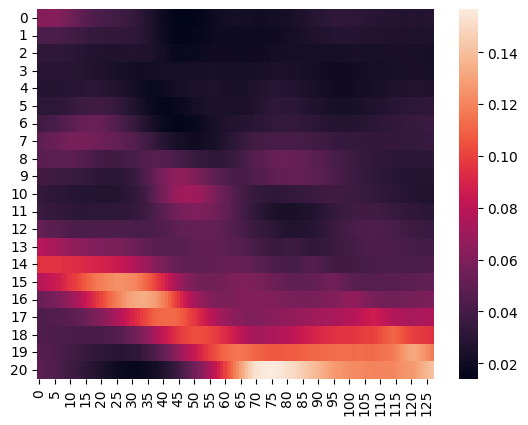

In [181]:
import seaborn as sns

print(all_attn.shape)
print(all_corrs.shape)

sns.heatmap(all_attn.mean(axis=0).T, cbar=True)

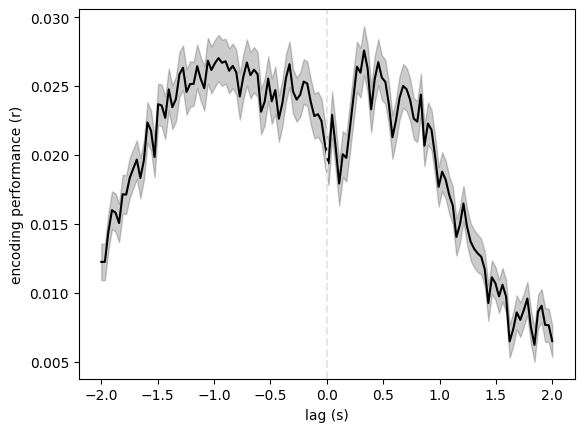

In [192]:
from matplotlib import pyplot as plt

lags = np.linspace(-pre_stimulus, tmax, brain_timep) 
mean = all_corrs.mean((0, 1))
# std = correlations_time.std((0)) 
std = all_corrs.std((0, 1)) / np.sqrt(np.product(all_corrs.shape[:2]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

Coordinate matrix shape:  (235, 3)


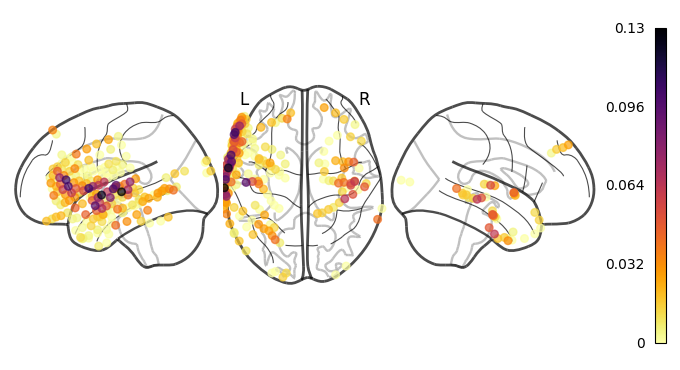

In [197]:
from nilearn.plotting import plot_markers

raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = all_corrs.mean((0,2)).argsort()
plot_markers(all_corrs.mean((0,2))[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

## Evaluation

In [218]:
from torchmetrics.functional import pearson_corrcoef

correlations_time = np.zeros((y_pred_all.shape[0], y_pred_all.shape[2]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for tp in range(y_pred_all.shape[2]):
        pred = y_pred_sample[:, tp]
        target = y_true_sample[:, tp]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_time[sample, tp] = corr.item()

100%|██████████| 513/513 [00:07<00:00, 65.53it/s]


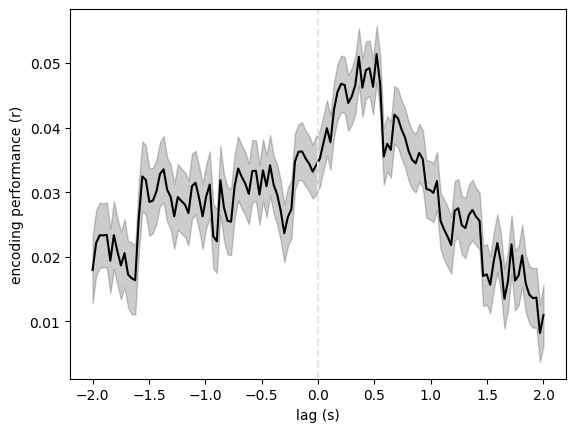

In [219]:
from matplotlib import pyplot as plt

n_array = 100

lags = np.linspace(-pre_stimulus, tmax, brain_timep) 
# value_array = y_pred_all[:,n_array,:].mean((0))
mean = correlations_time.mean((0))
std = correlations_time.std((0)) / np.sqrt(np.product(correlations_time.shape[:1]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

In [220]:
from torchmetrics.functional import pearson_corrcoef

correlations_channels = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for channel in range(y_pred_all.shape[1]):
        pred = y_pred_sample[channel, :]
        target = y_true_sample[channel, :]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_channels[sample, channel] = corr.item()

100%|██████████| 513/513 [00:11<00:00, 44.42it/s]


In [221]:
correlations_channels_mean = np.nanmean(correlations_channels, axis=0)

Coordinate matrix shape:  (235, 3)


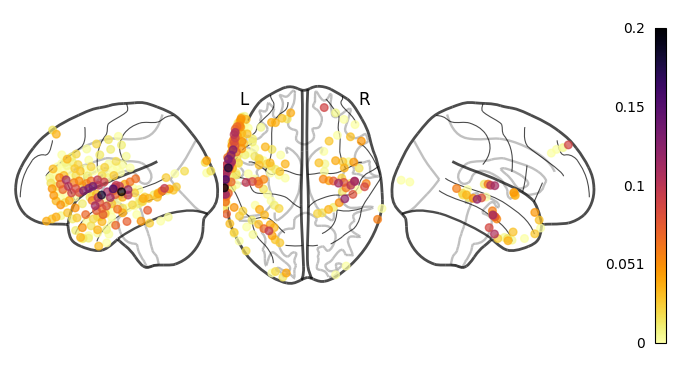

In [222]:
from nilearn.plotting import plot_markers

raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = correlations_channels_mean.argsort()
plot_markers(correlations_channels_mean[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()